# Binary Classification of the "Don't Patronize Me!" Dataset

Perform Binary Classification to predict whether a text contains patronizing and condescending language. The task was task 4 (subtask 1) in the SemEval 2022 competition.

## Initialize Environment

In [1]:
# Library imports
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt    

from nltk import PorterStemmer, WordNetLemmatizer
import codecs

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from tqdm import tqdm
import torch.nn as nn

import re
from functools import partial

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

# Pre-trained models
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel
from transformers.models.bert.modeling_bert import BertOnlyMLMHead
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler

from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch


def fix_seed(seed=420.69):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
#   np.random.seed(seed)
#   random.seed(seed)

fix_seed()

data_path = '../../bin/data'
embeddings_path = '../../bin/word_embeddings'

# from util.datafunctions import *
# from util.evaluation import *

if not torch.cuda.is_available():
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda'

DEVICE

2024-03-03 19:52:11.218008: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 19:52:11.242292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 19:52:11.242320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 19:52:11.243011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 19:52:11.247288: I tensorflow/core/platform/cpu_feature_guar

'cuda'

In [2]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Cuda available?  True
Found GPU at: /device:GPU:0


2024-03-03 19:52:13.266510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 19:52:13.267693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 19:52:13.267801: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## DataFunctions

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def generate_data_splits(train_data):
    # The stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. 

    X_train, X_val, y_train, y_val = train_test_split(train_data[['text', 'keyword', 'country_code']]
                                                    , train_data['labels']
                                                    , train_size=0.8
                                                    , test_size=0.2
                                                    , random_state=0
                                                    , stratify=train_data[['labels']]
                                                    )
   
    return X_train, X_val, y_train, y_val


def pie_data_distributions(pie_series, pie_series_label):
    """Plots some pie charts for data distribution (Assume len(pie_series) inputs)

    Args:
        pie_series (_type_): pandas series 
        pie_series_label (_type_): for the title
    """

    assert len(pie_series) == len(pie_series_label) and "expected inputs of same length"

    _, axs = plt.subplots(1, len(pie_series), figsize=(len(pie_series)*5, 5))

    for idx, (series, title) in enumerate(zip(pie_series, pie_series_label)):
        tmp = series.value_counts()

        wedges, _, _ = axs[idx].pie(tmp, labels=tmp.index, autopct='%1.1f%%', startangle=90)
        legend_labels = [f'{label} ({count})' for label, count in zip(tmp.index, tmp)]
        axs[idx].legend(wedges, legend_labels, title="Class 1 and 0", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        axs[idx].set_title(f'Distribution for {title}')

    plt.tight_layout()
    plt.show()

def plot_data_splits(X_train, X_val, y_train, y_val, test_data):
    print("=== DISTRIBUTION FOR TRAINING DATA ===")
    pie_data_distributions(
        [X_train['country_code'], X_train['keyword'], y_train],
        ['train country_code label', 'train keyword label', 'train binary classification']
    )

    print("=== DISTRIBUTION FOR VALIDATION DATA ===")
    pie_data_distributions(
        [X_val['country_code'], X_val['keyword'], y_val],
        ['validation country_code label', 'validation keyword label', 'validation binary classification']
    )

    print("=== DISTRIBUTION FOR TEST DATA ===")
    pie_data_distributions(
        [test_data['country_code'], test_data['keyword']],
        ['test country_code label', 'test keyword label']
    )


## Evaluation

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def performance_metrics(trainer, dataloader):
    predicted = []
    expected = []

    predictions = trainer.predict(dataloader)
    predictions = predictions.label_ids
    
    expected = np.array(dataloader.data['labels'])
    expected = expected.astype(int)

    print(classification_report(expected, predictions))

    set(predicted)
    cm = confusion_matrix(expected, predictions, labels=[0, 1]) 

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True));  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

    ax.set_title('Confusion Matrix')

    ax.xaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])
    ax.yaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])

    plt.show()


# def model_prediction(model):
#     """Given a model and input for the forward pass, will output pretty-printed output"""
#     # Get one random sample from the test data
#     random_index = X_val.sample(n=1).index.values[0]

#     while random_index not in train_data.index:
#         random_index = X_val.sample(n=1).index.values[0]

#     # Extract random sample
#     tdf = train_data.loc[[random_index]][['text', 'label']]
#     test_paragraph, real_label = tdf['text'].values[0], tdf['label'].values[0]

#     # Get model prediction
#     predicted_label, _ = model.predict([tdf['text'].values[0]])

#     print(f"=== Paragraph example ===\n{test_paragraph.capitalize()}")
#     print(f"\tReal Label:      {real_label}")
#     print(f"\tModel Prediction:{predicted_label[0]}")


## Raw Data

### Loading

Load the data into pandas dataframes

In [5]:
# Import Data
train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'
test_data_path  = f'{data_path}/task4_test.tsv'

train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])
test_data  = pd.read_csv(test_data_path,  delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text'])

train_data = train_data.drop(['art_id'], axis=1)
test_data = test_data.drop(['art_id'], axis=1)

In [6]:
# Concatenate label information to train data
dev_label_path   = f'{data_path}/dev_semeval_parids-labels.csv'
train_label_path = f'{data_path}/train_semeval_parids-labels.csv'

dev_label   = pd.read_csv(dev_label_path, delimiter=',')
train_label = pd.read_csv(train_label_path, delimiter=',')

detailed_labels = pd.concat([dev_label, train_label], ignore_index=True, join='inner', names=['simple', 'detailed'])
train_data = pd.merge(train_data, detailed_labels, on='par_id')
train_data = train_data.rename(columns={'label_x': 'binary_label', 'label_y': 'label_detailed'})

# give them a shuffle
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [7]:
# Add Binary Classification column for ease of checking
train_data.loc[:, 'labels'] = 0
train_data.loc[train_data['binary_label'].isin([2,3,4]), 'labels'] = 1

In [8]:
train_data = train_data.dropna(subset = 'text')
test_data = test_data.dropna(subset = 'text')

test_data['labels'] = -1 # for compatibility with the dataloader, set a dummy label variable

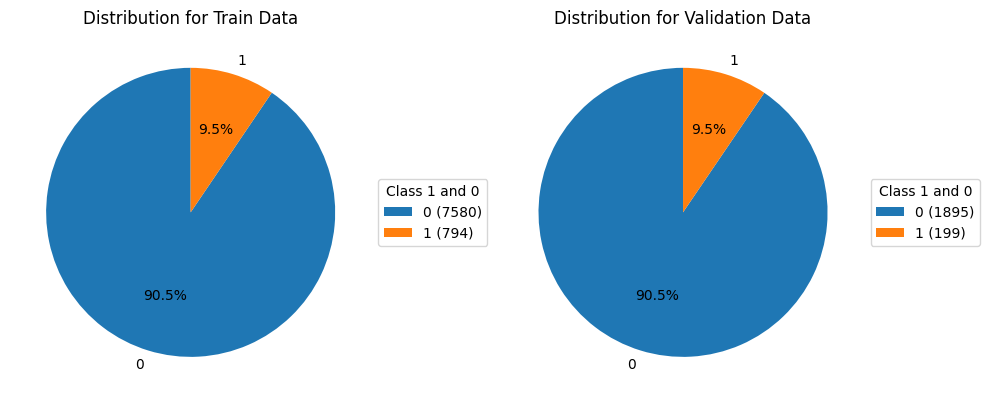

In [9]:
X_train, X_val, y_train, y_val = generate_data_splits(train_data)

pie_data_distributions([y_train, y_val], ['Train Data', 'Validation Data'])

# RoBERTa Baseline for Task 1

In [21]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [22]:
training_set1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
2377,1775,refugee,Last but not the least element of culpability ...,0
2378,1776,refugee,"Then , taking the art of counter-intuitive non...",0
2379,1777,refugee,Kagunga village was reported to lack necessary...,0
2380,1778,vulnerable,"""After her parents high-profile divorce after ...",0


In [23]:

task1_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing = False,
                                      use_multiprocessing_for_evaluation = False
                                      )


task1_model = ClassificationModel("roberta",
                                  'roberta-base',
                                  args = task1_model_args,
                                  num_labels=2,
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/21 [00:00<?, ?it/s]

In [24]:
Counter(preds_task1)

Counter({0: 1544, 1: 550})

In [25]:
labels2file([[k] for k in preds_task1], 'task1.txt')

## Prepare submission

In [ ]:
!cat task1.txt | head -n 10

0
0
0
1
0
0
0
0
0
0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
